In [1]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn import preprocessing



In [2]:
standardized_data = np.load(r'M:\work\project_program\bishe\pyproject\RL_pid_control_critic_actor\强化学习+Lstm\数据处理\全部原始数据列表.npy',allow_pickle=True)
standardized_data[0]

,一回路压力平均值,一环路冷热段平均值,堆芯出口温度平均值,主蒸汽压力平均值,辅助给水流量平均值,重要厂用水系统压力,DeltaTsat平均值,安全壳压力平均值,SG1水位平均值,稳压器泄压箱压力,压缩空气系统压力,汽机旁路系统蒸汽阀平均开度
0,15.38940,309.8145,333.440,6.670185,0.000,0.012031,11.1279,100.982,0.000157,0.015751,0.815506,0.000000
1,15.38710,309.8350,333.435,6.670212,0.000,0.012031,11.0896,100.982,0.001192,0.015750,0.815518,0.000000
2,15.37960,309.8325,333.431,6.670265,0.000,0.012031,11.0466,100.982,0.002432,0.015747,0.815531,0.000000
3,15.37100,309.8280,333.427,6.670345,0.000,0.012031,11.0160,100.982,0.003747,0.015747,0.815543,0.000000
4,15.36540,309.8290,333.423,6.670438,0.000,0.012031,10.9900,100.982,0.005079,0.015750,0.815555,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
4497,4.40247,227.8230,228.022,2.291215,38.947,194.972000,29.2856,101.121,1.800000,0.040001,0.871307,43.127167
4498,4.40247,227.8230,228.022,2.291215,38.947,194.972000,29.2856,101.121,1.800000,0.040001,0.871307,43.127167
4499,4.40247,227.8230,228.022,2.291215,38.947,194.972000,29.2856,101.121,1.800000,0.040001,0.871307,43.127167
4500,4.40247,227.8230,228.022,2.291215,38.947,194.972000,29.2856,101.121,1.800000,0.040001,0.871307,43.127167


In [3]:
#standardized_data[8]
print(len(standardized_data))

8


In [4]:
def get_concat_data(data):
    total_data_frame=pd.concat(data,ignore_index=True)
    return total_data_frame
concat_data=get_concat_data(standardized_data[:8])

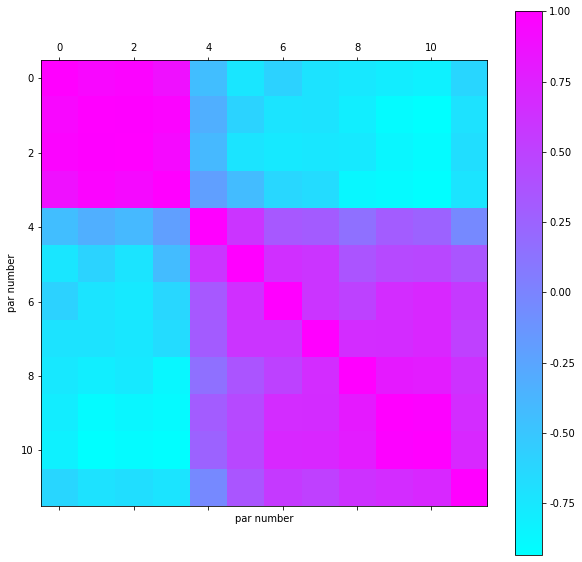

In [5]:
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(10, 10))
plt.matshow(np.corrcoef(concat_data.T), 0,cmap='cool',alpha=1)
plt.colorbar()
plt.xlabel("par number")
plt.ylabel("par number")
plt.show()

In [6]:
train_size, val_size = 0.5, 0.2


def preprocess(data_array: np.ndarray, train_size: float, val_size: float):
    """Splits data into train/val/test sets and normalizes the data.

    Args:
        data_array: ndarray of shape `(num_time_steps, num_routes)`
        train_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the train split.
        val_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the validation split.

    Returns:
        `train_array`, `val_array`, `test_array`
    """

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    # train_array = data_array[:num_train]
    # # mean, std = train_array.mean(axis=0), train_array.std(axis=0)
    # #
    # # train_array = (train_array - mean) / std
    # val_array = data_array[num_train : (num_train + num_val)]
    # test_array = data_array[(num_train + num_val) :]

    # 计算标准化时启用
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)

    train_array = (train_array - mean) / std
    val_array = (data_array[num_train : (num_train + num_val)] - mean) / std
    test_array = (data_array[(num_train + num_val) :] - mean) / std

    return train_array, val_array, test_array, mean, std






In [7]:
def get_lstm_data(data,sequence_len):
    features=[]
    target=[]
    data_len=len(data)
    for i in range(0,data_len-sequence_len):
        X=data.iloc[i:sequence_len+i][:].to_numpy()
        y=data.iloc[sequence_len+i][0:11].to_numpy()
        features.append(X)
        target.append(y)
    return np.array(features), np.array(target)



In [8]:
def create_batch_data(X,y,train=True,buffer_size=1000,batch_size=128):
    batch_data=tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    if train:
        return batch_data.cache().shuffle(buffer_size).batch(batch_size)
    else:
        return batch_data.batch(batch_size)



In [9]:

def get_data(divide:bool):
    if divide:
        train_datas, val_datas, test_datas,train_labels, val_labels, test_labels=[],[],[],[],[],[]
        for pdframe in standardized_data[:8]:
            train_array, val_array, test_array = preprocess(pdframe, train_size, val_size)
            train_dataset,train_label=get_lstm_data(train_array,10)
            val_dataset,val_label=get_lstm_data(val_array,10)
            test_dataset,test_label=get_lstm_data(test_array,10)
            train_datas.append(train_dataset)
            val_datas.append(val_dataset)
            test_datas.append(test_dataset)
            train_labels.append(train_label)
            val_labels.append(val_label)
            test_labels.append(test_label)
        train_datasets,train_label_sets=np.concatenate(train_datas, axis=0),np.concatenate(train_labels, axis=0)
        train_batch_dataset=create_batch_data(train_datasets,train_label_sets)
        val_datasets,val_label_sets=np.concatenate(val_datas, axis=0),np.concatenate(val_labels, axis=0)
        val_batch_dataset=create_batch_data(val_datasets,val_label_sets)
        test_datasets,test_label_sets=np.concatenate(test_datas, axis=0),np.concatenate(test_labels, axis=0)
        test_batch_dataset=create_batch_data(test_datasets,test_label_sets)
    else:
        train_array, val_array, test_array, mean, std = preprocess(concat_data, train_size, val_size)
        train_datasets,train_label_sets=get_lstm_data(train_array,10)
        val_datasets,val_label_sets=get_lstm_data(val_array,10)
        test_datasets,test_label_sets=get_lstm_data(test_array,10)
        train_batch_dataset=create_batch_data(train_datasets,train_label_sets)
        val_batch_dataset=create_batch_data(val_datasets,val_label_sets)
        test_batch_dataset=create_batch_data(test_datasets,test_label_sets)
    return train_batch_dataset,val_batch_dataset,test_batch_dataset,train_datasets,train_label_sets,val_datasets,val_label_sets,test_datasets,test_label_sets,mean,std


train_batch_dataset,val_batch_dataset,test_batch_dataset,train_datasets,train_label_sets,val_datasets,val_label_sets,test_datasets,test_label_sets,mean,std=get_data(False)

In [13]:
for i in train_batch_dataset.as_numpy_iterator():
    print(i)
    break
i[0].shape

(array([[[ 0.11432714,  1.13915216,  0.90956998, ..., -1.35574418,
         -0.82455491, -0.98277926],
        [ 0.11607856,  1.13954245,  0.90963479, ..., -1.35617758,
         -0.82372306, -0.98277926],
        [ 0.11876074,  1.14004982,  0.90976443, ..., -1.35592075,
         -0.82296053, -0.98277926],
        ...,
        [ 0.12893567,  1.14276232,  0.91026675, ..., -1.35466871,
         -0.81887061, -0.98277926],
        [ 0.13095064,  1.14325018,  0.91028296, ..., -1.35368954,
         -0.81803876, -0.98277926],
        [ 0.13304568,  1.14373803,  0.91026675, ..., -1.35311168,
         -0.81720691, -0.98277926]],

       [[ 2.38766737,  1.87734129,  2.22657381, ..., -1.35795934,
         -1.30806689, -0.98277926],
        [ 2.38740049,  1.87734129,  2.2265576 , ..., -1.35820012,
         -1.30716572, -0.98277926],
        [ 2.3871336 ,  1.87730226,  2.2265252 , ..., -1.35871378,
         -1.30633387, -0.98277926],
        ...,
        [ 2.38579919,  1.87714614,  2.22641177, ..., 

(128, 10, 12)

In [19]:
new_data=[train_datasets,mean,std]
dataa=np.array(new_data,dtype='object')
np.save ("用于训练lstm的数据.npy",dataa)


In [10]:
import numpy
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# Function to create deep learning model, required for KerasClassifierdef
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load dataset (这里可以自行载入数据集)
dataset = numpy.loadtxt("diabetes.csv", delimiter=",")
# split into input (X) and output (Y)
X = dataset[:,0:8]
Y = dataset[:,8]
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
# 设定的超参数batch_size取值范围
epochs = [10, 50, 100]
# 设定的超参数epochs取值范围
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

OSError: diabetes.csv not found.

In [11]:
def create_model():
    model=keras.Sequential([
        layers.LSTM(units=256,input_shape=(10,12),return_sequences=True),
        layers.Dropout(0.4),
        layers.LSTM(units=256,return_sequences=True),
        layers.Dropout(0.3),
        layers.LSTM(units=128,return_sequences=True),
        layers.LSTM(units=32),
        layers.Dense(11)
    ])
    #keras.utils.plot_model(model)
    model.compile(optimizer='sgd',loss='mse')
    return model

In [12]:
model=create_model()
check_point_fill='best_model.hdf5'
check_point_callback=tf.keras.callbacks.ModelCheckpoint(filepath=check_point_fill,moniter='loss',save_best_only=True,save_weights_only=True)
history = model.fit(train_batch_dataset,epochs=100,validation_data=val_batch_dataset,callbacks=[check_point_callback])

Epoch 1/100
120/120 [==============================] - 10s 15ms/step - loss: 0.8340 - val_loss: 0.4724
Epoch 2/100
120/120 [==============================] - 1s 9ms/step - loss: 0.4886 - val_loss: 0.3107
Epoch 3/100
120/120 [==============================] - 1s 10ms/step - loss: 0.3386 - val_loss: 0.2668
Epoch 4/100
120/120 [==============================] - 1s 10ms/step - loss: 0.2769 - val_loss: 0.2364
Epoch 5/100
120/120 [==============================] - 1s 9ms/step - loss: 0.2304 - val_loss: 0.2113
Epoch 6/100
120/120 [==============================] - 1s 9ms/step - loss: 0.1947 - val_loss: 0.1942
Epoch 7/100
120/120 [==============================] - 1s 9ms/step - loss: 0.1707 - val_loss: 0.1838
Epoch 8/100
120/120 [==============================] - 1s 9ms/step - loss: 0.1548 - val_loss: 0.1767
Epoch 9/100
120/120 [==============================] - 1s 9ms/step - loss: 0.1439 - val_loss: 0.1719
Epoch 10/100
120/120 [==============================] - 1s 10ms/step - loss: 0.1354 - v

KeyboardInterrupt: 

In [49]:
model.load_weights('best_model.hdf5')

In [13]:
import numpy
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
batch_size = [10, 20, 40, 60, 80, 100]
# 设定的超参数batch_size取值范围
epochs = [10, 50, 100]
# 设定的超参数epochs取值范围
param_grid = dict(batch_size=batch_size, epochs=epochs)
model = KerasRegressor(build_fn=create_model, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(train_datasets,train_label_sets)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.047244 using {'batch_size': 60, 'epochs': 10}
-0.081433 (0.080008) with: {'batch_size': 10, 'epochs': 10}
-0.072846 (0.047059) with: {'batch_size': 10, 'epochs': 50}
-0.093574 (0.052330) with: {'batch_size': 10, 'epochs': 100}
-0.071463 (0.056816) with: {'batch_size': 20, 'epochs': 10}
-0.099777 (0.108879) with: {'batch_size': 20, 'epochs': 50}
-0.103310 (0.069758) with: {'batch_size': 20, 'epochs': 100}
-0.060283 (0.063515) with: {'batch_size': 40, 'epochs': 10}
-0.069749 (0.046523) with: {'batch_size': 40, 'epochs': 50}
-0.077756 (0.061222) with: {'batch_size': 40, 'epochs': 100}
-0.047244 (0.044020) with: {'batch_size': 60, 'epochs': 10}
-0.089147 (0.078110) with: {'batch_size': 60, 'epochs': 50}
-0.070503 (0.039363) with: {'batch_size': 60, 'epochs': 100}
-0.060706 (0.065502) with: {'batch_size': 80, 'epochs': 10}
-0.088119 (0.097880) with: {'batch_size': 80, 'epochs': 50}
-0.093030 (0.075056) with: {'batch_size': 80, 'epochs': 100}
-0.054422 (0.065697) with: {'batch_size'

In [50]:
val_datasets.shape

(6089, 10, 12)

In [51]:
val_predict=model.predict(val_datasets,verbose=1)

191/191 [==============================] - 1s 4ms/step


In [52]:
val_predict.shape

(6089, 11)

In [53]:
val_label_sets.shape

(6089, 11)

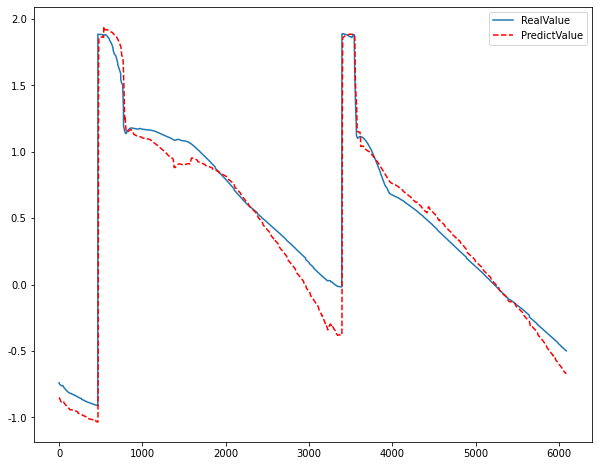

In [54]:
plt.figure(figsize=(10,8))
plt.plot(val_label_sets[:,1],label="RealValue")
plt.plot(val_predict[:,1],'r--',label="PredictValue")
plt.legend()
plt.show()

In [55]:
test_predict=model.predict(test_datasets,verbose=1)

286/286 [==============================] - 1s 4ms/step


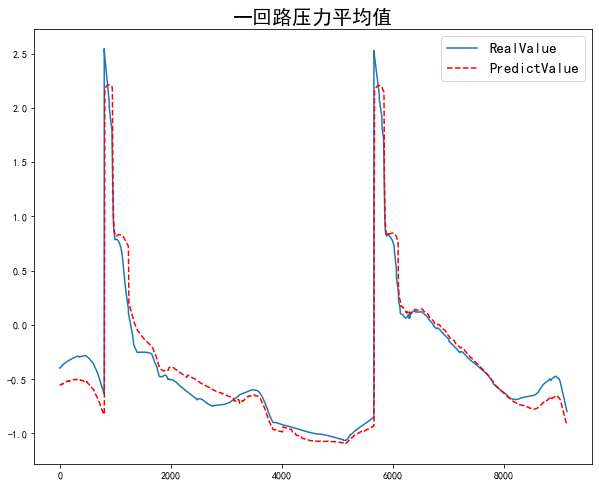

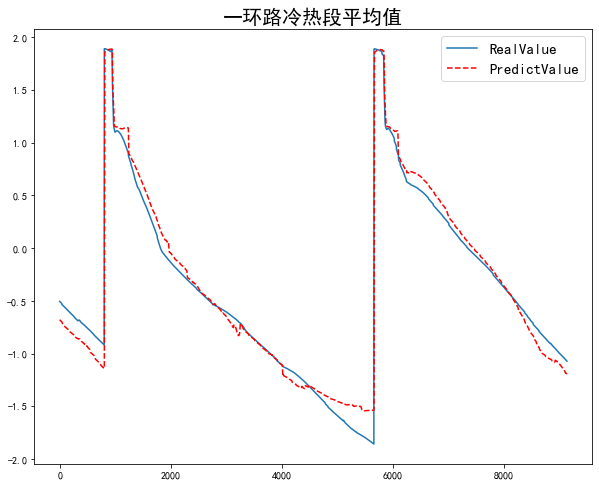

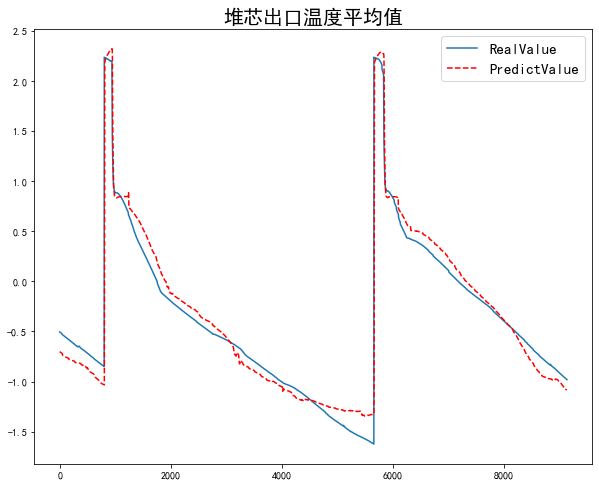

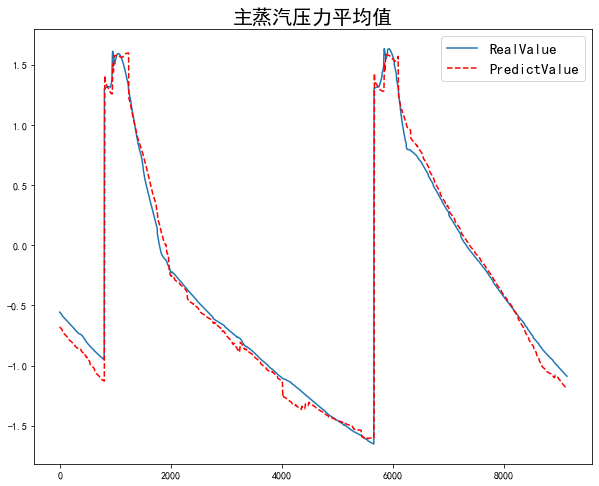

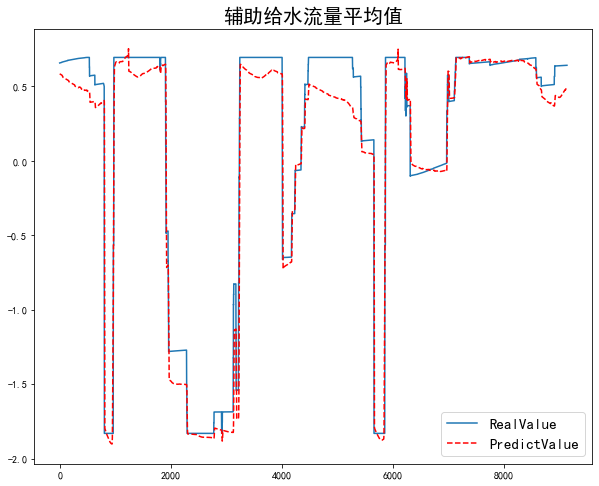

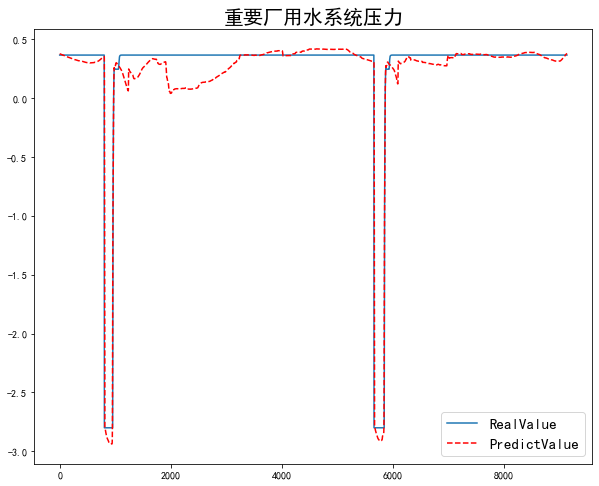

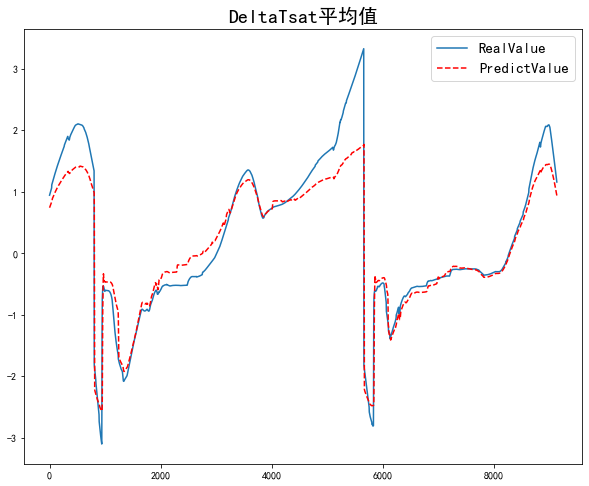

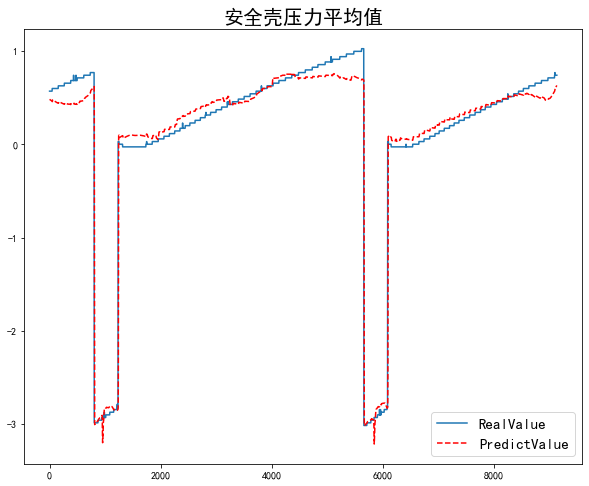

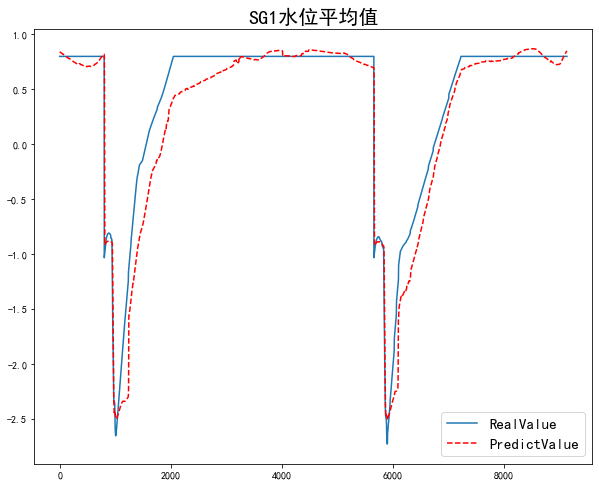

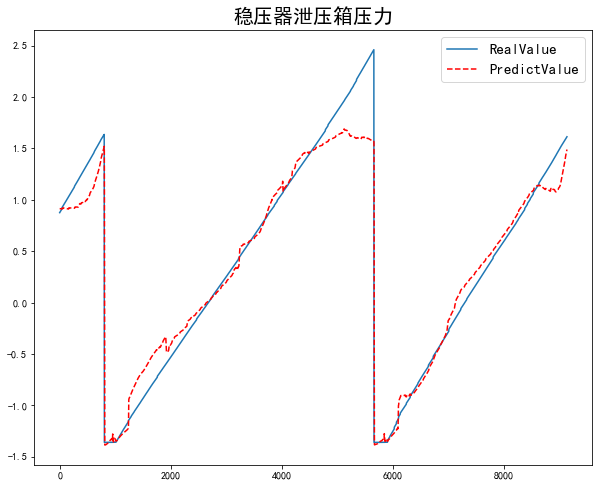

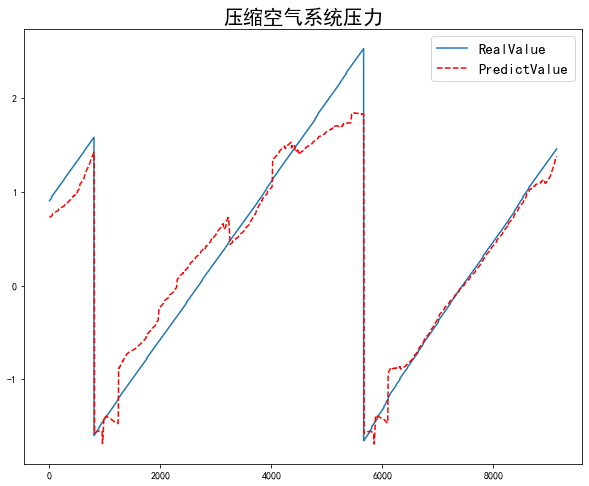

In [59]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显⽰中文
plt.rcParams['axes.unicode_minus'] = False  # 显⽰负号
labels_str=standardized_data[0].columns.tolist()[:11]
for i in range(11):
    plt.figure(figsize=(10,8))
    plt.plot(test_label_sets[:,i],label="RealValue")
    plt.plot(test_predict[:,i],'r--',label="PredictValue")
    plt.title(labels_str[i],fontsize=20)
    plt.legend(fontsize=15)
    #plt.savefig(f"D:\\file_comb\\研究生毕业论文\\中期检查\\ppt\\图片\\{labels_str[i]}.svg",dpi=300, bbox_inches='tight')
    plt.show()

In [130]:
train_datasets.shape

(15238, 10, 12)

In [148]:

from tqdm import tqdm
state=np.array([train_datasets[1800]])
result=[state]
for i in tqdm(range(1800,2800)):
    n_state=model.predict(state)
    temp=n_state.tolist()
    temp[0].append(train_datasets[i,9,11])
    temp=np.array(temp).reshape(1,1,12)
    new=np.concatenate((state,temp),axis=1)
    new=np.delete(new,0,1)
    result.append(new)
    state=new
result

100%|██████████| 1000/1000 [00:29<00:00, 33.66it/s]


[array([[[ 5.53875607e-03, -1.58162347e-01, -2.51291219e-01,
          -3.46590334e-01,  6.93496389e-01,  3.63393196e-01,
           1.36808102e+00,  1.99071965e-01, -1.73215388e-01,
          -6.39461760e-01, -1.45697160e-01,  1.04713340e+00],
         [ 2.69311089e-03, -1.61050472e-01, -2.53462568e-01,
          -3.47891199e-01,  6.93496389e-01,  3.63393196e-01,
           1.36706957e+00,  1.99071965e-01, -1.72025854e-01,
          -6.39076515e-01, -1.44934632e-01,  9.31284050e-01],
         [-1.42526161e-04, -1.63899568e-01, -2.55585304e-01,
          -3.49119878e-01,  6.93496389e-01,  3.63393196e-01,
           1.36594974e+00,  1.99071965e-01, -1.70794127e-01,
          -6.37936833e-01, -1.44102784e-01,  8.16775639e-01],
         [-2.93813069e-03, -1.66729150e-01, -2.57675632e-01,
          -3.50274866e-01,  6.93496389e-01,  3.63393196e-01,
           1.36492624e+00,  1.99071965e-01, -1.69660511e-01,
          -6.36620580e-01, -1.43270935e-01,  7.02265033e-01],
         [-5.7370712

In [149]:
bbb=result[0]
ccc=bbb.reshape(10,12)

In [150]:
result[1][0,9]

array([-0.03457052, -0.23808894, -0.32766277, -0.2890662 ,  0.64054632,
        0.40706393,  1.25349033,  0.20921423,  0.01353382, -0.42326629,
       -0.2916947 , -0.46492366])

In [151]:

for i in result[1:]:
    ccc=np.append(ccc,i[0,9].reshape(1,12),axis=0)


In [152]:
ccc

array([[ 5.53875607e-03, -1.58162347e-01, -2.51291219e-01, ...,
        -6.39461760e-01, -1.45697160e-01,  1.04713340e+00],
       [ 2.69311089e-03, -1.61050472e-01, -2.53462568e-01, ...,
        -6.39076515e-01, -1.44934632e-01,  9.31284050e-01],
       [-1.42526161e-04, -1.63899568e-01, -2.55585304e-01, ...,
        -6.37936833e-01, -1.44102784e-01,  8.16775639e-01],
       ...,
       [-8.46411169e-01, -1.05878615e+00, -9.53161478e-01, ...,
         5.20011187e-01,  1.06618118e+00,  3.40428254e+00],
       [-8.46411049e-01, -1.05878627e+00, -9.53161359e-01, ...,
         5.20010829e-01,  1.06618071e+00,  3.40428254e+00],
       [-8.46410513e-01, -1.05878615e+00, -9.53161240e-01, ...,
         5.20008683e-01,  1.06617880e+00,  3.40428254e+00]])

In [153]:
train_array, val_array, test_array = preprocess(concat_data, train_size, val_size)

In [25]:
concat_data

,一回路压力平均值,一环路冷热段平均值,堆芯出口温度平均值,主蒸汽压力平均值,辅助给水流量平均值,重要厂用水系统压力,DeltaTsat平均值,安全壳压力平均值,SG1水位平均值,稳压器泄压箱压力,压缩空气系统压力,汽机旁路系统蒸汽阀平均开度
0,15.38940,309.8145,333.4400,6.670185,0.00000,0.012031,11.12790,100.982,0.000157,0.015751,0.815506,0.000000
1,15.38710,309.8350,333.4350,6.670212,0.00000,0.012031,11.08960,100.982,0.001192,0.015750,0.815518,0.000000
2,15.37960,309.8325,333.4310,6.670265,0.00000,0.012031,11.04660,100.982,0.002432,0.015747,0.815531,0.000000
3,15.37100,309.8280,333.4270,6.670345,0.00000,0.012031,11.01600,100.982,0.003747,0.015747,0.815543,0.000000
4,15.36540,309.8290,333.4230,6.670438,0.00000,0.012031,10.99000,100.982,0.005079,0.015750,0.815555,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
30492,5.41185,234.1555,234.2155,2.700808,48.95040,194.972000,35.68020,101.114,1.800000,0.034256,0.860816,23.333333
30493,5.40540,234.1400,234.1995,2.700058,48.95080,194.972000,35.62160,101.114,1.800000,0.034258,0.860828,23.333333
30494,5.39904,234.1255,234.1850,2.699313,48.95115,194.972000,35.56230,101.114,1.800000,0.034260,0.860840,23.333333
30495,5.39264,234.1110,234.1705,2.698565,48.95155,194.972000,35.50240,101.114,1.800000,0.034268,0.860852,23.333333


In [26]:
temperature=concat_data['一环路冷热段平均值'].tolist()
start_temp=temperature[0]
result=[]
for num,val in enumerate(temperature[1:]):
    speed=(val-start_temp)*3600
    start_temp=val
    result.append(speed)
result



[73.79999999989195,
 -8.999999999991815,
 -16.200000000026193,
 3.6000000001195076,
 8.999999999991815,
 5.399999999872307,
 9.00000000019645,
 7.199999999829743,
 5.400000000076943,
 3.6000000001195076,
 -1.800000000162072,
 0.0,
 -3.5999999999148713,
 -3.6000000001195076,
 -3.5999999999148713,
 -3.5999999999148713,
 -3.6000000001195076,
 -1.7999999999574356,
 -1.800000000162072,
 -1.7999999999574356,
 -3.5999999999148713,
 0.0,
 -3.5999999999148713,
 -1.7999999999574356,
 -3.6000000001195076,
 -3.6000000001195076,
 -1.7999999999574356,
 -5.399999999872307,
 -3.5999999999148713,
 -3.6000000001195076,
 -3.6000000001195076,
 -1.7999999999574356,
 -3.5999999999148713,
 -3.5999999999148713,
 -5.400000000076943,
 -3.6000000001195076,
 -3.5999999999148713,
 -3.5999999999148713,
 -3.5999999999148713,
 -5.40000000028158,
 -3.5999999999148713,
 -3.5999999999148713,
 0.0,
 -3.6000000001195076,
 2.0463630789890885e-10,
 -1.800000000162072,
 -1.7999999999574356,
 -1.800000000162072,
 -1.799999999

In [29]:
index=[]
for num,val in enumerate(result):
    if -66<val<-46:
        index.append(num)
index

[758,
 900,
 916,
 973,
 1024,
 1026,
 1027,
 1028,
 1029,
 1030,
 1031,
 1032,
 1033,
 1034,
 1039,
 1479,
 1480,
 1481,
 1482,
 1483,
 1484,
 1485,
 1486,
 1487,
 1488,
 2194,
 2195,
 2196,
 2197,
 2198,
 2199,
 2200,
 2201,
 2202,
 2203,
 2204,
 2218,
 2221,
 2223,
 2833,
 2835,
 2838,
 2839,
 2840,
 2841,
 2842,
 2843,
 2844,
 2845,
 2846,
 2847,
 2848,
 2849,
 2850,
 2851,
 2852,
 2853,
 2854,
 2855,
 2856,
 2857,
 2858,
 2859,
 2860,
 2861,
 2862,
 2863,
 2864,
 2865,
 2866,
 2867,
 2868,
 2869,
 2870,
 2871,
 2872,
 2873,
 2874,
 2875,
 2876,
 2877,
 2878,
 2879,
 2880,
 2881,
 2882,
 2883,
 2884,
 2885,
 2886,
 2887,
 2888,
 2889,
 2890,
 2891,
 2892,
 2893,
 2894,
 2895,
 2896,
 2897,
 2898,
 2899,
 2900,
 2901,
 2902,
 2903,
 2904,
 2905,
 2906,
 2907,
 2908,
 2909,
 2910,
 2911,
 2912,
 2913,
 2914,
 2915,
 2916,
 2917,
 2918,
 2919,
 2920,
 2921,
 2922,
 2923,
 2925,
 2926,
 2927,
 2928,
 2929,
 2930,
 2931,
 2932,
 2933,
 2934,
 2935,
 2936,
 2937,
 2938,
 2939,
 2941,
 29

In [31]:
start_end_satisfy=[]
window=[index[0]]
for num,val in enumerate(index[1:]):
    if val-window[-1]<10:
        window.append(val)
    else:
        start_end_satisfy.append((window[0],window[-1]))
        window=[index[num+1]]

start_end_satisfy


[(758, 758),
 (900, 900),
 (916, 916),
 (973, 973),
 (1024, 1039),
 (1479, 1488),
 (2194, 2204),
 (2218, 2223),
 (2833, 2997),
 (3089, 3176),
 (3192, 3192),
 (3416, 3416),
 (3642, 3666),
 (4344, 4456),
 (4715, 4733),
 (4744, 4786),
 (4845, 4845),
 (4909, 4917),
 (5347, 5352),
 (5769, 5795),
 (6515, 6517),
 (6542, 7354),
 (7364, 7417),
 (7429, 8050),
 (8088, 8097),
 (8107, 8128),
 (8166, 8166),
 (8191, 8191),
 (8206, 8206),
 (8224, 8246),
 (8256, 8298),
 (8308, 8310),
 (8329, 8333),
 (8345, 8345),
 (8361, 8379),
 (8391, 8399),
 (8424, 8431),
 (8455, 8455),
 (8708, 8728),
 (8739, 8741),
 (8866, 8876),
 (9034, 9041),
 (9397, 9452),
 (9599, 10150),
 (10186, 10188),
 (10226, 10230),
 (10256, 10263),
 (10282, 10282),
 (10336, 10336),
 (10384, 10384),
 (10398, 10400),
 (10410, 10410),
 (10420, 11731),
 (11759, 11759),
 (11783, 11835),
 (11903, 11903),
 (12322, 12344),
 (12448, 12458),
 (12527, 12529),
 (13014, 13014),
 (13045, 13045),
 (13094, 13094),
 (13143, 13474),
 (13491, 13519),
 (13531

In [33]:
maxval=0
best=None
for i in start_end_satisfy:
    start,end=i
    dis=end-start
    if dis>maxval and end<15000:
        best=i
        maxval=dis
best

(10420, 11731)

In [154]:
train_array["汽机旁路系统蒸汽阀平均开度"].max()

3.4042825392508207

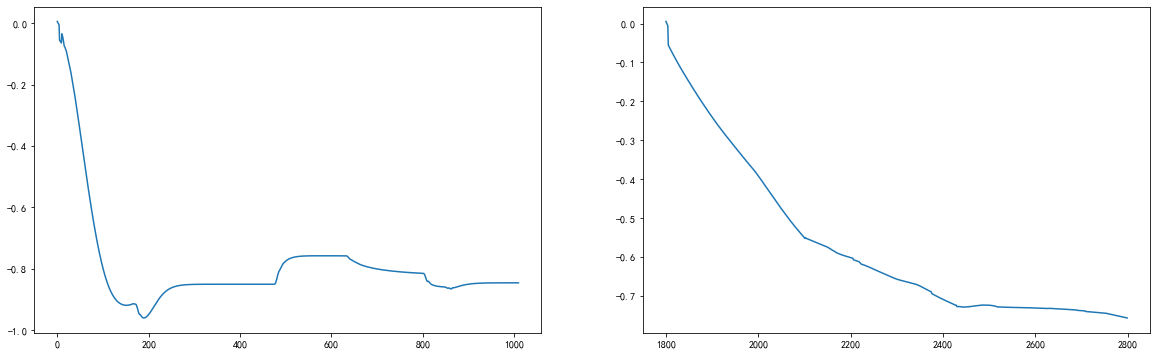

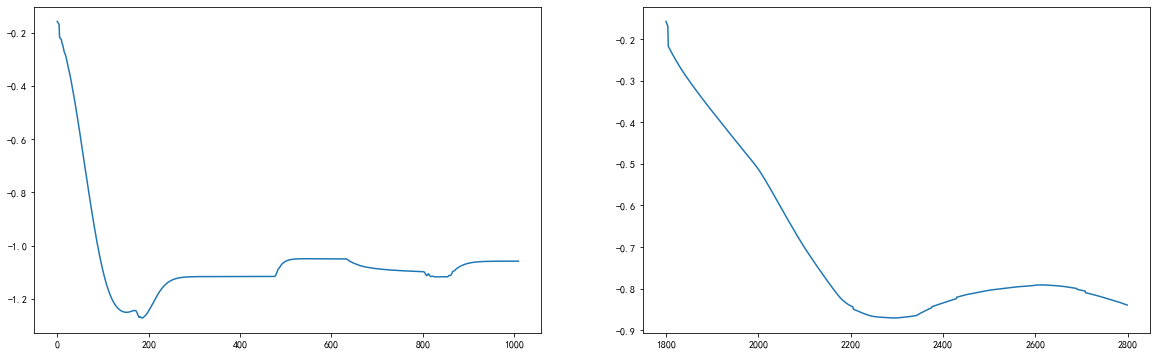

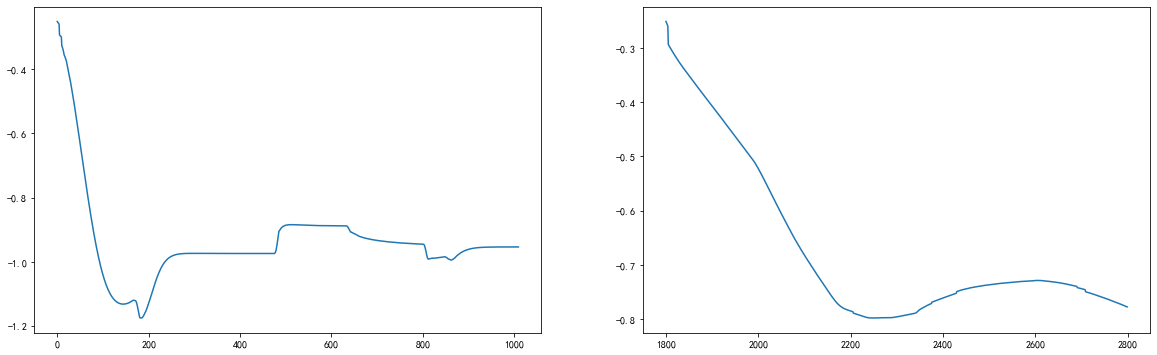

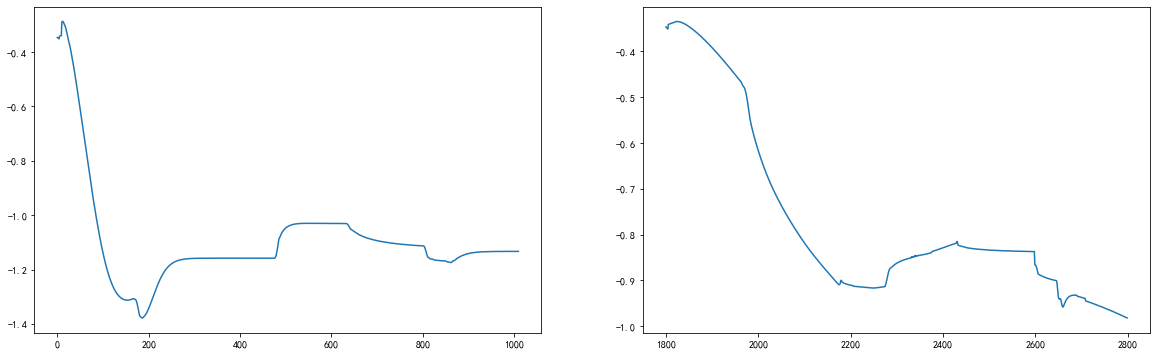

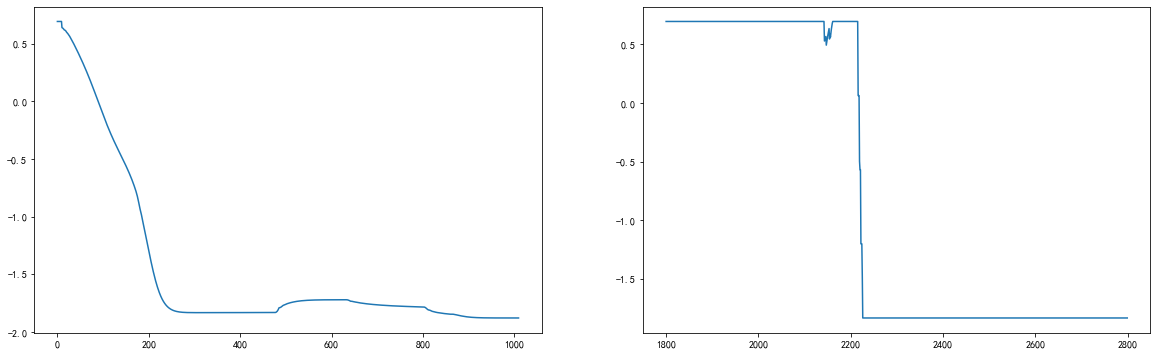

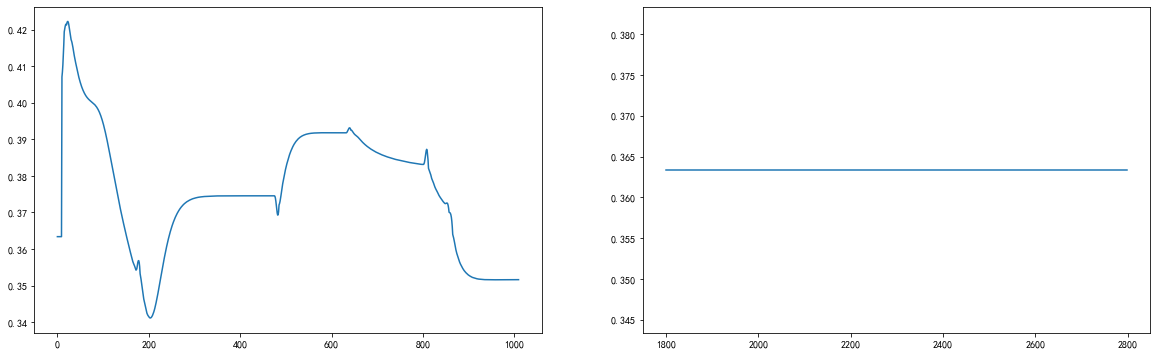

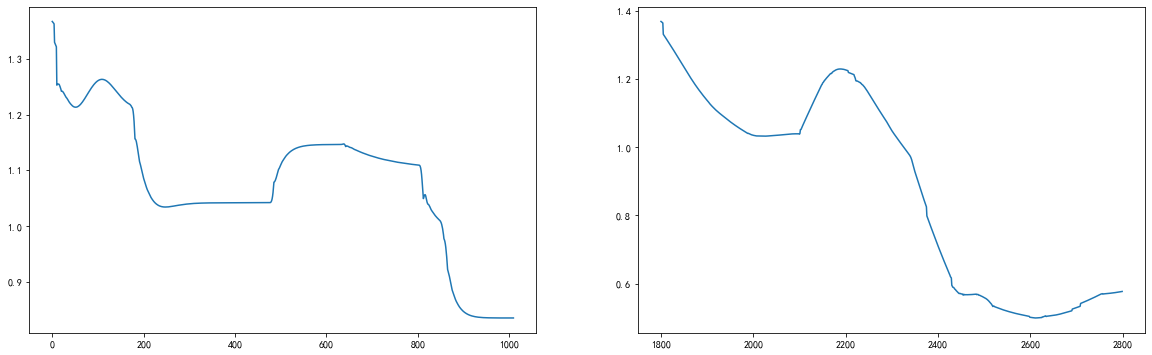

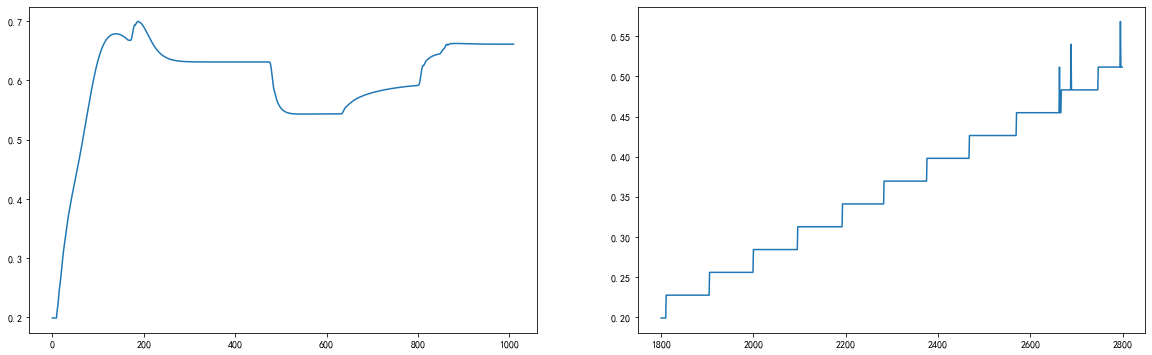

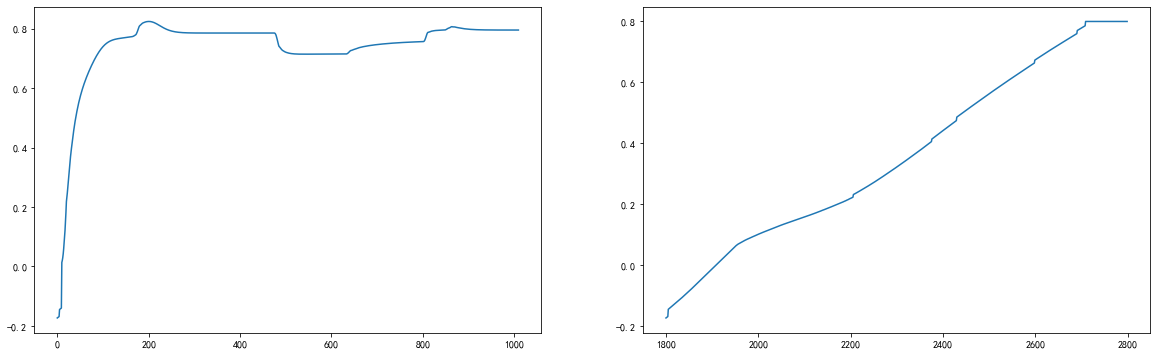

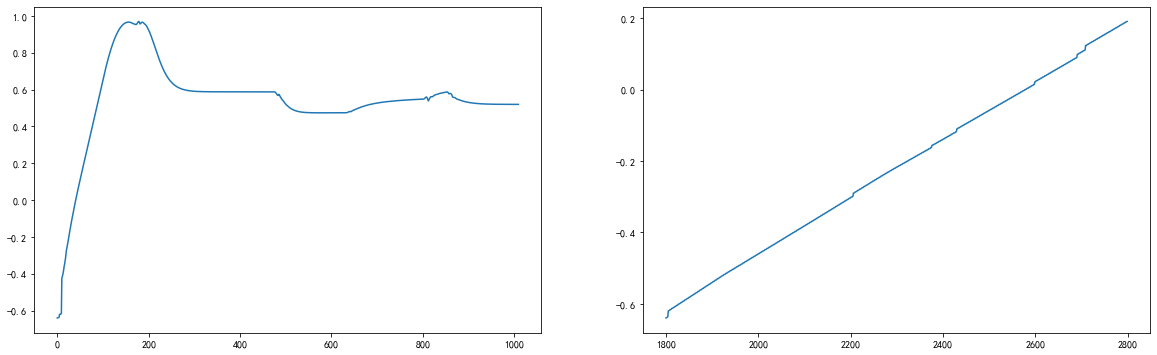

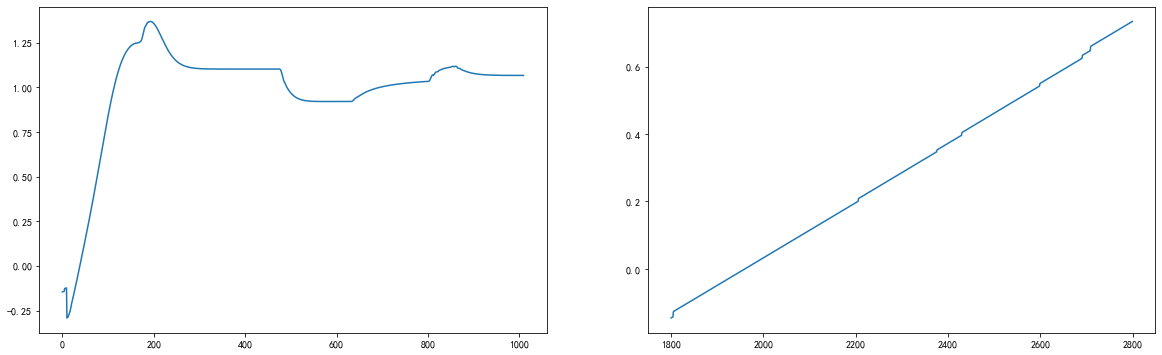

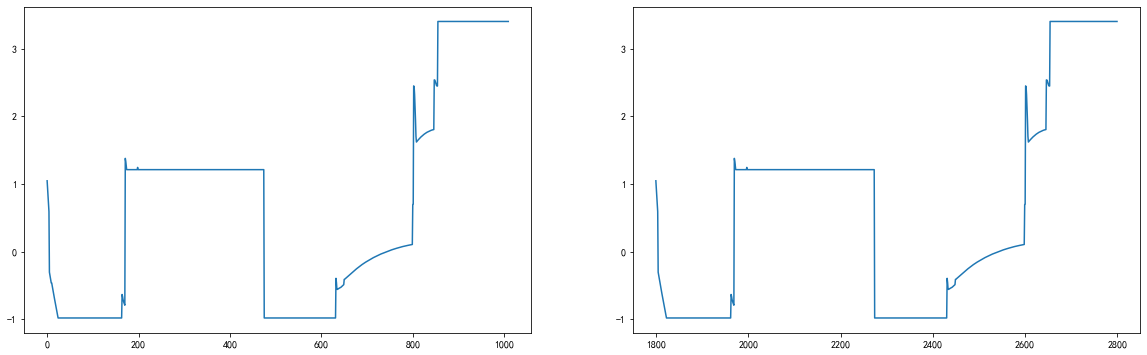

In [158]:

for i in range(12):
    plt.figure(figsize=(20,6))
    plt.subplot(1,2,1)
    plt.plot(ccc[:,i])
    plt.subplot(1,2,2)
    plt.plot(train_array.iloc[1800:2800,i])

    plt.show()